# Inference with pretrained Nucleotide Transformer models

[![Open All Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/instadeepai/nucleotide-transformer/blob/main/examples/inference.ipynb)

## Installation and imports

In [1]:
!pip install matplotlib

Looking in indexes: https://pypi.org/simple, https://packagecloud.io/github/git-lfs/pypi/simple


In [1]:
import os

try:
    import nucleotide_transformer
except:
    !pip install numpy==1.23.5
    !pip install git+https://github.com/instadeepai/nucleotide-transformer@main |tail -n 1
    import nucleotide_transformer

if "COLAB_TPU_ADDR" in os.environ:
    from jax.tools import colab_tpu

    colab_tpu.setup_tpu()
import haiku as hk
import jax
import jax.numpy as jnp
from nucleotide_transformer.pretrained import load_pretrained_model
import numpy as np
np.set_printoptions(threshold=np.inf)

## Download the weights
The following cell allows you to download the weights of any of the four nucleotide transformer model. It returns the weights dictionary, the haiku forward function, the tokenizer and the config dictionary.

Please also specify:
1. the layers at which you'd like to collect embeddings (e.g. (5, 10, 20) to get embeddings at layers 5, 10 and 20)
2. the attention maps you´d like to collect (e.g. ((1,4), (7,18)) to get attention maps corresponding to layer 1 head number 4 and layer 7 head number 18). Please refer to the config to see the number of layers and heads in the model.
3. the maximum number of tokens in the sequences you'll compute the inference on. You can put values up to value specified in the model's config (counting the class token that will be added automatically at the beginning of the sequence), however we recommend keeping this number as small as possible for optimized memory and inference time.

In [2]:
#@title Select a model
#@markdown ---
model_name = '50M_multi_species_v2'#@param['500M_human_ref', '500M_1000G', '2B5_1000G', '2B5_multi_species', '50M_multi_species_v2', '100M_multi_species_v2', '250M_multi_species_v2', '500M_multi_species_v2', '1B_agro_nt']
#@markdown ---

In [3]:
# Get pretrained model
parameters, forward_fn, tokenizer, config = load_pretrained_model(
    model_name=model_name,
    model_path='/home/noxatras/Desktop/nutr_github',
    embeddings_layers_to_save=(range(1,13)),
    attention_maps_to_save=((1, 4), (7, 16)),
    max_positions=32,
)
forward_fn = hk.transform(forward_fn)

loading model's hyperparameters json file... from /home/noxatras/Desktop/nutr_github
loading model's weights...
Downloaded model's weights...


In [4]:
print(config)

NucleotideTransformerConfig(alphabet_size=4107, pad_token_id=1, mask_token_id=2, max_positions=2048, embed_scale=1.0, emb_layer_norm_before=False, attention_heads=16, key_size=32, embed_dim=512, ffn_embed_dim=2048, num_layers=12, positional_embedding=None, add_bias_kv=False, add_bias_ffn=False, use_rotary_embedding=True, rescaling_factor=None, ffn_activation_name='swish', use_glu_in_ffn=True, layer_norm_eps=1e-05, pre_layer_norm=True, token_dropout=False, masking_ratio=0.0, masking_prob=0.0, use_gradient_checkpointing=False, embeddings_layers_to_save=(12,), attention_maps_to_save=((1, 4), (7, 16)))


In [75]:
import h5py
#ith h5py.File('transcripts_database_test1.h5', 'r') as hdf:
chrm='2'
file = h5py.File('/home/noxatras/Desktop/nutr_tutorial/transcripts_database_test3.h5', 'r')
transcripts = {file['transcript']['id'][i].decode('utf-8'): file['transcript']['sequence'][i].decode('utf-8') for i,j in enumerate(file['transcript']['id']) if file['transcript']['chrm'][i].decode('utf-8') ==chrm}
file.close()

In [62]:
print(transcripts['ENST00000437295'])

KeyError: 'ENST00000437295'

## Define your input data and tokenize it
You can have a look at the tokens_str variable to see how your sequences have been split into tokens. The sequences will all be padded to the value you filled for max_positions.

In [76]:
# Get data and tokenize it
sequences = [transcripts[k][:30] for k in list(transcripts.keys())[:10]]
id=[k for k in list(transcripts.keys())[:10]]
print(sequences[0])
print(id[0])
tokens_ids = [b[1] for b in tokenizer.batch_tokenize(sequences)]
tokens_str = [b[0] for b in tokenizer.batch_tokenize(sequences)]
tokens = jnp.asarray(tokens_ids, dtype=jnp.int32)

GGGGCGCGCCCGGCGCGACGCGGAGCAGGC
ENST00000567327


## Do the Inference
The first time you query this cell will be slower than usual inference because of the computation graph compilation.

In [77]:
%%time
# Initialize random key
random_key = jax.random.PRNGKey(0)

# Infer
outs = forward_fn.apply(parameters, random_key, tokens)

CPU times: user 1.31 s, sys: 37.5 ms, total: 1.35 s
Wall time: 254 ms


In [45]:
print(outs.keys())

dict_keys(['attention_map_layer_1_number_4', 'attention_map_layer_7_number_16', 'embeddings_1', 'embeddings_10', 'embeddings_11', 'embeddings_12', 'embeddings_2', 'embeddings_3', 'embeddings_4', 'embeddings_5', 'embeddings_6', 'embeddings_7', 'embeddings_8', 'embeddings_9', 'logits'])


In [54]:
logits=outs[f'embeddings_12']
print(logits.shape)

(10, 32, 512)


In [72]:
file.close()

In [79]:
file = h5py.File('/home/noxatras/Desktop/nutr_tutorial/transcripts_database_test3.h5', 'r+')
print([i for i in file])
print([i for i in file['embeddings_1']])
print([i for i in file['embeddings_1']['id'][0].decode('utf-8')])
print([i for i in file['embeddings_1']['logits'].shape])
print([i for i in file['embeddings_1']['chrm']])
# for i in range(1,13):
#     del file[f'embeddings_{i}']
# print([i for i in file])

file.close()

['embeddings_1', 'embeddings_10', 'embeddings_11', 'embeddings_12', 'embeddings_2', 'embeddings_3', 'embeddings_4', 'embeddings_5', 'embeddings_6', 'embeddings_7', 'embeddings_8', 'embeddings_9', 'transcript']
['chrm', 'id', 'logits']
['E', 'N', 'S', 'T', '0', '0', '0', '0', '0', '4', '9', '3', '4', '0', '9']
[20, 32, 512]
[b'10', b'10', b'10', b'10', b'10', b'10', b'10', b'10', b'10', b'10', b'2', b'2', b'2', b'2', b'2', b'2', b'2', b'2', b'2', b'2']


In [78]:
import h5py
import numpy as np

id = [k for k in list(transcripts.keys())[:10]]

# Assuming `outs` contains the embeddings and `ids` contains the IDs
with h5py.File('/home/noxatras/Desktop/nutr_tutorial/transcripts_database_test3.h5', 'r+') as hdf:
    for i in range(1, 13):
        logits = outs[f'embeddings_{i}']  # Adjusted to use the correct index
        group_name = f'embeddings_{i}'
        
        # Check if the group exists
        if group_name in hdf:
            group = hdf[group_name]
        else:
            group = hdf.create_group(group_name)
        
        # Append to or create 'id' dataset
        if 'id' in group:
            id_dataset = group['id']
            id_dataset.resize((id_dataset.shape[0] + len(id),))
            id_dataset[-len(id):] = id
        else:
            group.create_dataset('id', data=id, maxshape=(None,))
        
        # Append to or create 'logits' dataset
        if 'logits' in group:
            logits_dataset = group['logits']
            logits_dataset.resize((logits_dataset.shape[0] + logits.shape[0], logits.shape[1], logits.shape[2]))
            logits_dataset[-logits.shape[0]:] = logits
        else:
            group.create_dataset('logits', data=logits, maxshape=(None, logits.shape[1], logits.shape[2]))
        
        # Append to or create 'chrm' dataset
        if 'chrm' in group:
            chrm_dataset = group['chrm']
            chrm_dataset.resize((chrm_dataset.shape[0] + len(id),))
            chrm_dataset[-len(id):] = [chrm for _ in range(len(id))]
        else:
            group.create_dataset('chrm', data=[chrm for _ in range(len(id))], maxshape=(None,))

print("Embeddings saved successfully.")

Embeddings saved successfully.


In [ ]:
import h5py
import numpy as np

def load_and_split_h5(file_path, dataset_name, batch_size):
    with h5py.File(file_path, 'r') as f:
        data = f[dataset_name]
        n_seq, seq_len, n_embed = data.shape
        
        for start_idx in range(0, n_seq, batch_size):
            end_idx = min(start_idx + batch_size, n_seq)
            yield data[start_idx:end_idx]

# Example usage
file_path = 'path_to_your_file.h5'
dataset_name = 'your_dataset_name'
batch_size = 32

for batch in load_and_split_h5(file_path, dataset_name, batch_size):
    # Process each batch
    print(batch.shape)

## Retrieve embeddings
And use them as you please! Enjoy!

In [8]:
print(outs["embeddings_12"].shape)
#n_sample x n_positions x n_features

(10, 32, 512)


**Additional Tip**: Don't forget to remove the cls token and padded positions if you want for instance to compute mean embeddings!

In [29]:
embeddings = outs["embeddings_12"][:, 1:, :]  # removing CLS token
padding_mask = jnp.expand_dims(tokens[:, 1:] != tokenizer.pad_token_id, axis=-1)
masked_embeddings = embeddings * padding_mask  # multiply by 0 pad tokens embeddings
sequences_lengths = jnp.sum(padding_mask, axis=1)
mean_embeddings = jnp.sum(masked_embeddings, axis=1) / sequences_lengths

In [30]:
print(padding_mask.shape)
print(masked_embeddings.shape)
print(sequences_lengths.shape)
print(mean_embeddings.shape)

(3, 31, 1)
(3, 31, 512)
(3, 1)
(3, 512)


In [10]:
print(mean_embeddings.shape)

(2, 512)


In [11]:
print(mean_embeddings)

[[ 0.03073177  0.28487873 -0.02410994 ... -0.00697623 -0.10268426
  -0.20914507]
 [-0.17261794 -0.13952523 -0.12027188 ...  0.15793535  0.15447876
  -0.12072131]]


## Get attention maps
Here is an example on how to retrieve attention maps at a specific layer for a given head and how to plot them.

In [32]:
print(outs["attention_map_layer_1_number_4"].shape)

(2, 32, 32)


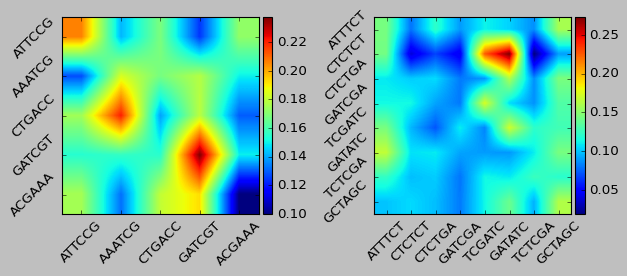

In [33]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# plot attention maps
fig, axes = plt.subplots(nrows=1, ncols=2)

seq_length0, seq_length1 = int(sequences_lengths[0][0]), int(sequences_lengths[1][0])

# plot for first seq in the batch
im0 = axes[0].imshow(
    outs["attention_map_layer_1_number_4"][
        0, 1 : (seq_length0 + 1), 1 : (seq_length0 + 1)
    ]
)
divider0 = make_axes_locatable(axes[0])
cax0 = divider0.append_axes("right", size="5%", pad=0.05)
tokens0 = tokens_str[0][1 : (seq_length0 + 1)]
axes[0].set_xticks(list(range(seq_length0)), tokens0, rotation=45)
axes[0].set_yticks(list(range(seq_length0)), tokens0, rotation=45)
fig.colorbar(im0, cax=cax0, orientation="vertical")

# plot for second seq in the batch
im1 = axes[1].imshow(
    outs["attention_map_layer_1_number_4"][
        1, 1 : (seq_length1 + 1), 1 : (seq_length1 + 1)
    ]
)
divider1 = make_axes_locatable(axes[1])
cax1 = divider1.append_axes("right", size="5%", pad=0.05)
tokens1 = tokens_str[1][1 : (seq_length1 + 1)]
axes[1].set_xticks(list(range(seq_length1)), tokens1, rotation=45)
axes[1].set_yticks(list(range(seq_length1)), tokens1, rotation=45)
fig.colorbar(im1, cax=cax1, orientation="vertical")

fig.tight_layout()

## Get probabilities
Finally, let's look at the model probabilities over the vocabulary at each position. These can be used notably to compute reconstruction accuracies and perplexities.

In [34]:
logits = outs["logits"]
probabilities = []

# get probabilities separately for each seq as they have different lengths
for seq_id in range(logits.shape[0]):

    logits_seq = logits[seq_id]
    seq_length = int(sequences_lengths[seq_id][0])
    logits_seq = logits_seq[1 : (seq_length + 1)]  # remove CLS token and pads
    probas = jax.nn.softmax(
        logits_seq, axis=-1
    )  # use softmax to transform logits into probabilities

    print(probas.shape)
    probabilities.append(probas)

(5, 4107)
(8, 4107)


Let's look in particular at a given sequence and position and show the top-k probabilities and corresponding tokens.

In [35]:
sequence_id = 0
position_id = 1

probs = probabilities[sequence_id][position_id]
sorted_positions = jnp.argsort(-probs)
sorted_probs = probs[sorted_positions]

top_k = 5
for k in range(top_k):
    predicted_token = tokenizer.id_to_token(int(sorted_positions[k]))
    prob = sorted_probs[k]
    print(f"token: {predicted_token}, probability: {prob * 100:.2f}%")

token: AAATCG, probability: 95.13%
token: AAATCC, probability: 1.93%
token: AAATCA, probability: 0.70%
token: AAGTCA, probability: 0.19%
token: AAACCA, probability: 0.14%
